In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## defining sample function to be used in the code

#fx= x^3-4x^2+10x+100 fx'=3x^2-8x+10 (27-24+10) m=13; here b^2−4ac < 0 which implies slope can never be negative. if b^2−4ac = 0 the slopt intercepts x at one place, if greather than 0 then at 2 places.
def f(x):
    return x**3-4*x**2+10*x+100

f(3)

In [ ]:
## plotting graph to see slope

xs = np.arange(-5,5,0.25)
ys = f(xs)

plt.plot(xs,ys)

In [ ]:
## running a basic derivative calculation

h = 0.001
x = -300
(f(x+h)-f(x))/h

In [4]:
## code for visualizing equation/neuron

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [29]:
## base micrograd class

class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self.grad=0
        self._backward = lambda: None
           
    
    def __repr__(self):
        return f"Value: data({self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self,other),'+')
        
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self,other),'*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self,other): # other*value
        return self * other
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other-1) *out.grad
        out._backward = _backward
        return out
            
    def __truediv__(self,other):
        return self * other**-1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out= Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x =self.data
        out = Value(math.exp(x), (self,), 'exp')    
        
        def _backward():
            self.grad += math.exp(x)*out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set() 
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()


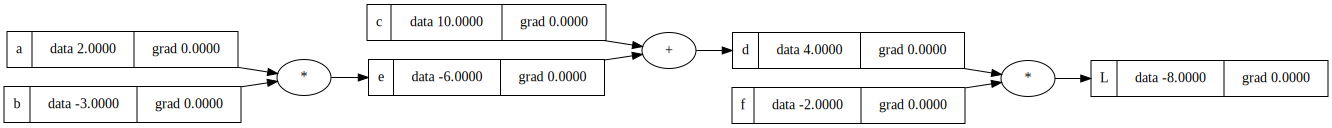

In [18]:
## example 1
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

draw_dot(L)

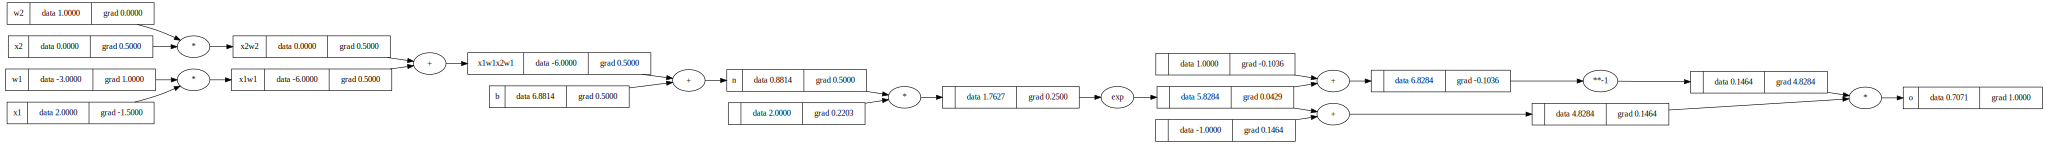

In [19]:
## using a single neuron and backpropagating through it.

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373358870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w1 = x1w1 + x2w2; x1w1x2w1.label = 'x1w1x2w1'
n = x1w1x2w1 + b; n.label = 'n'

# ---
e = (2*n).exp()
o = (e-1)/(1+e); o.label = 'o'
# ---

# o=n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
## Manual Backward pass

o.grad=1
n.grad = 1 - o.data**2 # tanh'(x) = 1 - tanh^2(x)
x1w1x2w1.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w1.grad
x2w2.grad = x1w1x2w1.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

draw_dot(o)

In [ ]:
## using the _backward method to do the backward pass

o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w1._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)

In [ ]:
## defining topological sort

topo = []
visited = set()

def topo_sort(v):
    if v not in visited:
        # print(v)
        visited.add(v)
        for _child in v._prev:
            topo_sort(_child)
        topo.append(v)

topo_sort(o)
topo


In [ ]:
## using the topological sort to do the backward pass

o.grad = 1.0

topo = []
visited = set()
topo_sort(o)

for node in reversed(topo):
    node._backward()
draw_dot(o)

In [ ]:
## using the backward method to do the backward pass

o.backward()
draw_dot(o)

In [25]:
## verifying that we are accumulating gradients due to chain rule of multivariable calculus. each variable affects the output in a different way and we are accumulating that.

a = Value(3.0, label='a')
b = a + a ; b.label = 'b'  
b.backward()
draw_dot(b)

a=Value(2, label='a')
b=Value(4, label='b')
# a/b
# a-b 

In [106]:
## create a minimal MLP from scratch

import random
random.seed(10)

class Neuron:
    def __init__(self, nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
        
    def __call__(self,x):
        out=sum((x1*w1 for x1,w1 in zip(x,self.w)),self.b)
        return out.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.layers=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        out = [neuron(x) for neuron in self.layers]
        return out[0] if len(out)==1 else out
    
    def parameters(self):
        params=[]
        for neuron in self.layers:
            params.extend(neuron.parameters())
        return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers=[Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]
            
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params=[]
        for layer in self.layers:
                params.extend(layer.parameters())
        return params

x = [2,3,4]
n = MLP(3,[4,5,3,1])
n(x)

Value: data(-0.7451079966496381)

In [107]:
# input data to fit on

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [110]:
# writing a simple training loop
for i in range(20):
    ys_pred=[n(x) for x in xs]
    loss=sum((ypred-ygt)**2 for ypred, ygt in zip(ys_pred, ys))
    print(f"Loss: {loss.data}")
    
    for p in n.parameters():
        p.grad=0
    loss.backward()

    for p in n.parameters():
        p.data += p.grad * -0.05


Loss: 0.01696544210352148
Loss: 0.016481258257905092
Loss: 0.01602262204358296
Loss: 0.01558760819166332
Loss: 0.015174477612886022
Loss: 0.014781655620473408
Loss: 0.014407713120528484
Loss: 0.014051350310932131
Loss: 0.013711382508785043
Loss: 0.013386727790571998
Loss: 0.013076396181470336
Loss: 0.012779480172970517
Loss: 0.012495146383103962
Loss: 0.01222262820255444
Loss: 0.011961219293935458
Loss: 0.01171026783147518
Loss: 0.011469171385005382
Loss: 0.01123737236609541
Loss: 0.011014353965889621
Loss: 0.010799636524080062


In [111]:
ys_pred=[n(x) for x in xs]
ys_pred

[Value: data(0.9529526991720361),
 Value: data(-0.968968873558465),
 Value: data(-0.9427046232826343),
 Value: data(0.935706650731323)]